In [1]:
from pandas import read_csv
from datetime import datetime
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import pandas as pd

import numpy as np
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import pickle
from keras import backend as K


Using TensorFlow backend.


In [2]:
# load data

currencies = ['EURAUD', 'EURCAD', 'EURCHF', 'EURGBP', 'EURJPY', 'EURUSD', 'EURCZK', 'EURDKK', 'EURHKD', 'EURHUF', 'EURMXN', 'EURNOK', 'EURNZD', 'EURPLN', 'EURRUB', 'EURRUR', 'EURSEK', 'EURTRY', 'EURZAR']
#currencies = ['EURAUD', 'EURCAD', 'EURCHF', 'EURGBP', 'EURJPY', 'EURUSD', 'EURNZD']
#currencies = ['EURGBP', 'EURCAD']

def builData(currencies):
    
    print('Loading data and parsing date')    
    
    data = {}
       
    for curr in currencies:
        print('Reading currency: ', curr)
        
        df = read_csv(curr + '.csv', delimiter='\t')
        #if n_c < limit:
        #    limit = n_c
        col = df['<CLOSE>'].tolist()

        data[curr] = col
      
        print('Data processed succesfully ')

        # dataset.index.name = 'date'

        # dataset.drop('Unnamed: 0', axis=1, inplace=True)

        # mark all NA values with 0

    return data

In [3]:
curr_key = currencies
data = builData(currencies)
#data.to_pickle('multi_model')

Loading data and parsing date
Reading currency:  EURAUD
Data processed succesfully 
Reading currency:  EURCAD
Data processed succesfully 
Reading currency:  EURCHF
Data processed succesfully 
Reading currency:  EURGBP
Data processed succesfully 
Reading currency:  EURJPY
Data processed succesfully 
Reading currency:  EURUSD
Data processed succesfully 
Reading currency:  EURCZK
Data processed succesfully 
Reading currency:  EURDKK
Data processed succesfully 
Reading currency:  EURHKD
Data processed succesfully 
Reading currency:  EURHUF
Data processed succesfully 
Reading currency:  EURMXN
Data processed succesfully 
Reading currency:  EURNOK
Data processed succesfully 
Reading currency:  EURNZD
Data processed succesfully 
Reading currency:  EURPLN
Data processed succesfully 
Reading currency:  EURRUB
Data processed succesfully 
Reading currency:  EURRUR
Data processed succesfully 
Reading currency:  EURSEK
Data processed succesfully 
Reading currency:  EURTRY
Data processed succesfully

In [4]:
print('Dict size', len(data))

Dict size 19


In [5]:
def prepareData(dataset):
    #creating train and test sets

    start = 24 * 30 * 3
    # df.columns.drop(['Unnamed: 0', 'date'])
    
    data_curr ={}
    scalers = {}
    
    for curr, val in dataset.items():
        
        data = {}
        
        n_curr = len(val)

        train_size = int(n_curr*0.8)

        train = val[:train_size]
        valid = val[train_size:]
        #converting dataset into x_train and y_train
        
        train = np.reshape(train, (len(train), 1))
        valid = np.reshape(valid, (len(valid), 1))
        
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(train)
        scaled_data_test = scaler.transform(valid)

        x_train, y_train = [], []
        x_test, y_test = [], []

        lookback = 12
        for i in range(lookback,len(train)):
            x_train.append(scaled_data[i-lookback:i])
            y_train.append(scaled_data[i])

        for i in range(lookback,len(valid)):
            x_test.append(scaled_data_test[i-lookback:i])
            y_test.append(scaled_data_test[i])

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_test, y_test = np.array(x_test), np.array(y_test)

        x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1]))
        x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1]))
        
        data['x_train'] = x_train
        data['y_train'] = y_train
        data['x_test'] = x_test
        data['y_test'] = y_test
        data['scaler'] = scaler
        scalers[curr] = scaler
        data_curr[curr] = data
        
        print('For ', curr)
        
        print('x_train.shape ', x_train.shape)
    
        print('y_train.shape ', y_train.shape)
    
        #y_train = np.reshape(y_train, (y_train.shape[0],1))
        #y_test = np.reshape(y_test, (y_test.shape[0],1))

        #indices = np.arange(x_train.shape[0])
        #np.random.shuffle(indices)

        #x_train = x_train[indices, :, :]
        #y_train = y_train[indices, :]
    
    with open('scalers', 'wb') as handle:
        pickle.dump(scalers, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return data_curr

In [6]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def buildModel(data, curr_key):
    i = 0
    units = 20
    epoc = 3
    batch = 1
    
    x_train = data['x_train']
    y_train = data['y_train']
    
    # create and fit the LSTM network
    model = Sequential()
    #model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=units))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    X = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    y = y_train



    model.compile(loss='mean_squared_error', optimizer='Adamax')
    history = model.fit(X, y, epochs=epoc, batch_size=batch, verbose=1)
    filename = curr_key + '_model.sav'
    pickle.dump(model, open(filename, 'wb'))
    print('Model created ', curr_key)
        
    return model

def buildModels(data_curr):
    
    models = {}
    i = 0
    
    for curr, data in data_curr.items():
        model = buildModel(data, curr)
        models[curr] = model
        i += 1
        
    print(i, ' total models created')
    
    return models

In [7]:
def loadModel(curr_key):
    i = 0
    models = {}
    for curr in curr_key:
        # load the model from disk
        filename = curr + '_model.sav'
        loaded_model = pickle.load(open(filename, 'rb'))
        models[curr] = loaded_model
        print('Loaded model: ', filename)
    return models

In [8]:
def predict(data_curr, models):
    
    predictions = {}

    i = 0
    for curr, model in models.items():
        x_test = data_curr[curr]['x_test']
        X = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
        
        prediction = model.predict(X)
        predictions[curr] = prediction.reshape(prediction.shape[0], 1)
        i += 1
    return predictions

In [9]:
data_curr = prepareData(data)

For  EURAUD
x_train.shape  (53104, 12)
y_train.shape  (53104, 1)
For  EURCAD
x_train.shape  (53097, 12)
y_train.shape  (53097, 1)
For  EURCHF
x_train.shape  (52849, 12)
y_train.shape  (52849, 1)
For  EURGBP
x_train.shape  (53096, 12)
y_train.shape  (53096, 1)
For  EURJPY
x_train.shape  (53094, 12)
y_train.shape  (53094, 1)
For  EURUSD
x_train.shape  (53092, 12)
y_train.shape  (53092, 1)
For  EURCZK
x_train.shape  (26604, 12)
y_train.shape  (26604, 1)
For  EURDKK
x_train.shape  (21534, 12)
y_train.shape  (21534, 1)
For  EURHKD
x_train.shape  (45211, 12)
y_train.shape  (45211, 1)
For  EURHUF
x_train.shape  (27773, 12)
y_train.shape  (27773, 1)
For  EURMXN
x_train.shape  (28132, 12)
y_train.shape  (28132, 1)
For  EURNOK
x_train.shape  (36846, 12)
y_train.shape  (36846, 1)
For  EURNZD
x_train.shape  (53085, 12)
y_train.shape  (53085, 1)
For  EURPLN
x_train.shape  (27839, 12)
y_train.shape  (27839, 1)
For  EURRUB
x_train.shape  (9434, 12)
y_train.shape  (9434, 1)
For  EURRUR
x_train.shape  

In [10]:
models = buildModels(data_curr)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/3
53104/53104 [==============================] - 343s 6ms/step - loss: 1.0860e-04
Epoch 2/3
53104/53104 [==============================] - 334s 6ms/step - loss: 2.5138e-05
Epoch 3/3
53104/53104 [==============================] - 334s 6ms/step - loss: 2.3641e-05
Model created  EURAUD
Epoch 1/3
53097/53097 [==============================] - 331s 6ms/step - loss: 7.9410e-05
Epoch 2/3
53097/53097 [==============================] - 327s 6ms/step - loss: 2.7243e-05
Epoch 3/3
53097/53097 [==============================] - 328s 6ms/step - loss: 2.5472e-05
Model created  EURCAD
Epoch 1/3
52849/52849 [==============================] - 332s 6ms/step - loss: 8.6459e-05
Epoch 2/3
52849/52849 [==============================] - 335s 6ms/step - loss: 1.6103e-05
Epoch 3/3
52849/52849 [==============================] - 336s 6ms/step - loss: 1.2997e-05
Model created  EURCHF
Epoch 1/3
53096/53096 [===================

In [11]:
curr_key = currencies
models = loadModel(curr_key)

Loaded model:  EURAUD_model.sav
Loaded model:  EURCAD_model.sav
Loaded model:  EURCHF_model.sav
Loaded model:  EURGBP_model.sav
Loaded model:  EURJPY_model.sav
Loaded model:  EURUSD_model.sav
Loaded model:  EURCZK_model.sav
Loaded model:  EURDKK_model.sav
Loaded model:  EURHKD_model.sav
Loaded model:  EURHUF_model.sav
Loaded model:  EURMXN_model.sav
Loaded model:  EURNOK_model.sav
Loaded model:  EURNZD_model.sav
Loaded model:  EURPLN_model.sav
Loaded model:  EURRUB_model.sav
Loaded model:  EURRUR_model.sav
Loaded model:  EURSEK_model.sav
Loaded model:  EURTRY_model.sav
Loaded model:  EURZAR_model.sav


In [12]:
predictions = predict(data_curr, models)

In [13]:
drop_curr = []
test_scores = {}
for curr, data in models.items():
    y_pred = predictions[curr]
    y_test = data_curr[curr]['y_test']
    test_score = np.sqrt(np.mean(np.square(y_pred[1:] - y_test[:-1]), axis=0))
    ref = 0.01
    
    if test_score > ref:
        drop_curr.append(curr)
        
    print('For curr ', curr, 'RMSE on test set ', test_score)
    test_scores[curr] = test_score[0]
with open('test_scores', 'wb') as handle:
        pickle.dump(test_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
for curr in drop_curr:
    del models[curr]
    del predictions[curr]
    del data_curr[curr]
    print('Deleting currency : ', curr)

For curr  EURAUD RMSE on test set  [0.00486284]
For curr  EURCAD RMSE on test set  [0.00421853]
For curr  EURCHF RMSE on test set  [0.0006262]
For curr  EURGBP RMSE on test set  [0.00330008]
For curr  EURJPY RMSE on test set  [0.00025441]
For curr  EURUSD RMSE on test set  [0.0009376]
For curr  EURCZK RMSE on test set  [0.00622732]
For curr  EURDKK RMSE on test set  [0.00969601]
For curr  EURHKD RMSE on test set  [0.00218109]
For curr  EURHUF RMSE on test set  [0.01663054]
For curr  EURMXN RMSE on test set  [0.00700322]
For curr  EURNOK RMSE on test set  [0.00690667]
For curr  EURNZD RMSE on test set  [0.00119422]
For curr  EURPLN RMSE on test set  [0.00739164]
For curr  EURRUB RMSE on test set  [0.0034313]
For curr  EURRUR RMSE on test set  [0.00610388]
For curr  EURSEK RMSE on test set  [0.00219991]
For curr  EURTRY RMSE on test set  [0.00248737]
For curr  EURZAR RMSE on test set  [0.00728911]
Deleting currency :  EURHUF


In [14]:
horizon = 24*3

Plot currency  EURAUD


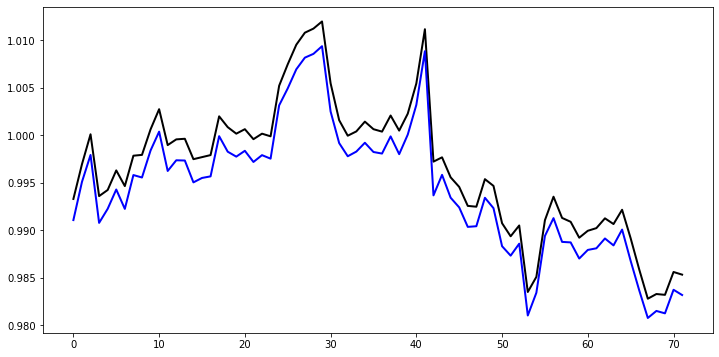

Plot currency  EURCAD


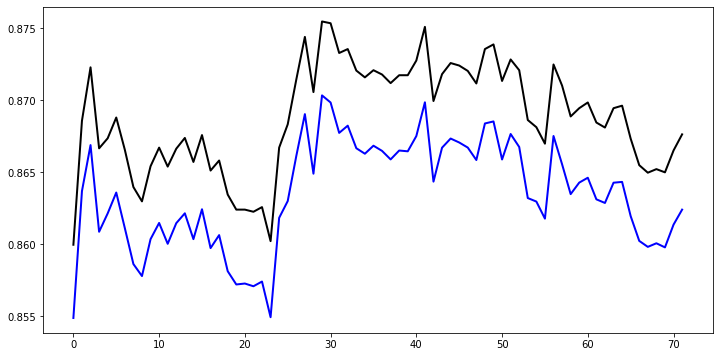

Plot currency  EURCHF


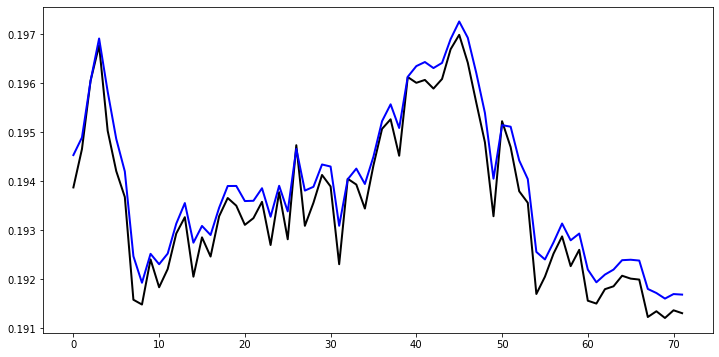

Plot currency  EURGBP


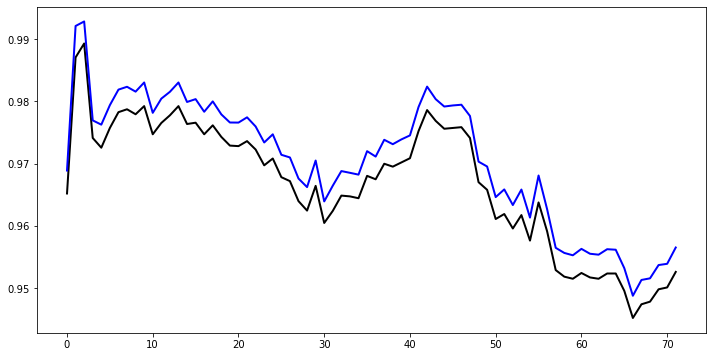

Plot currency  EURJPY


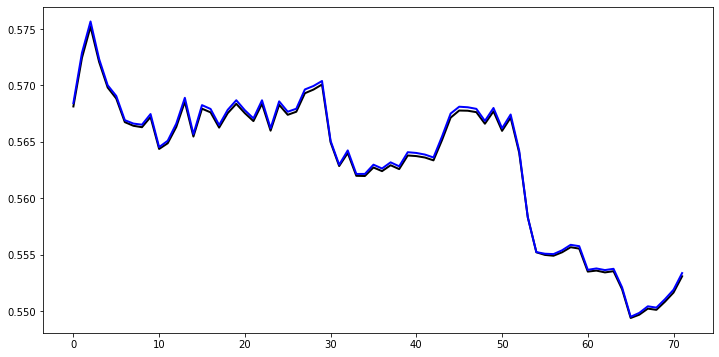

Plot currency  EURUSD


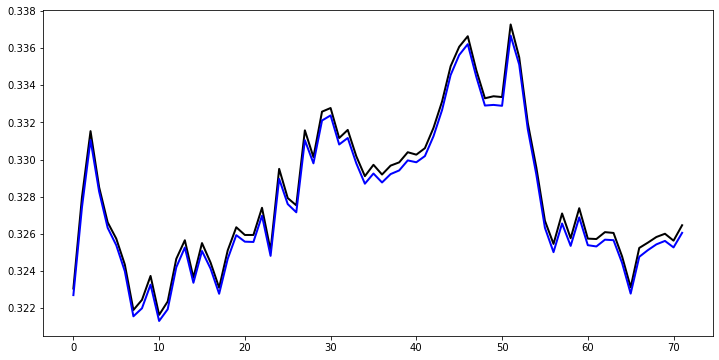

Plot currency  EURCZK


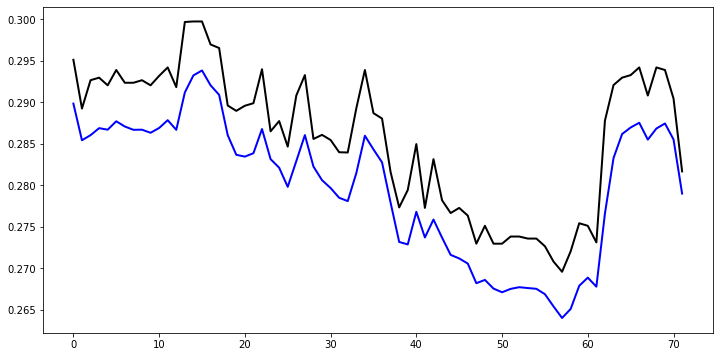

Plot currency  EURDKK


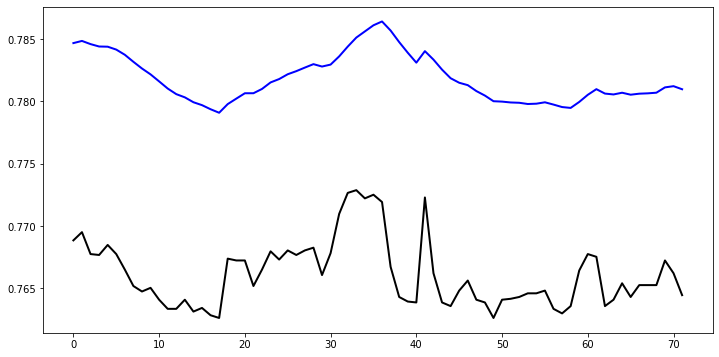

Plot currency  EURHKD


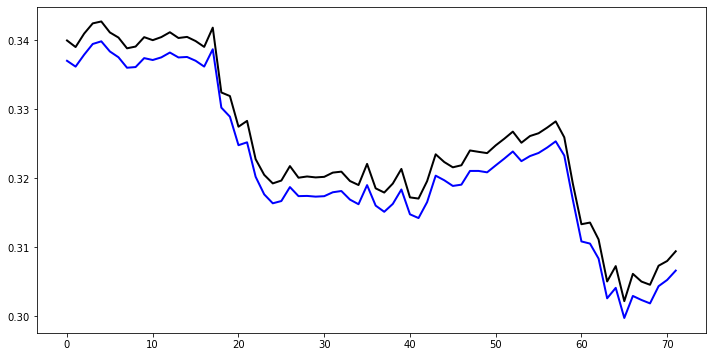

Plot currency  EURMXN


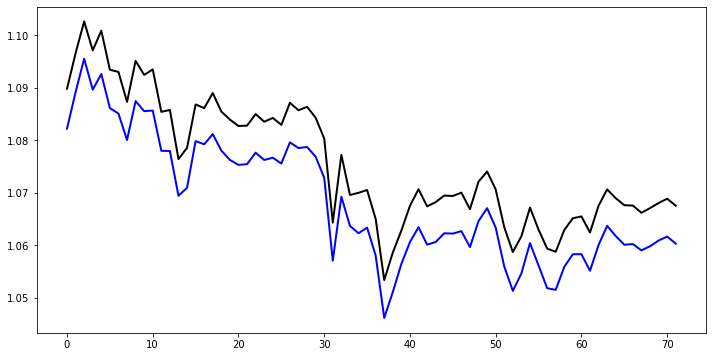

Plot currency  EURNOK


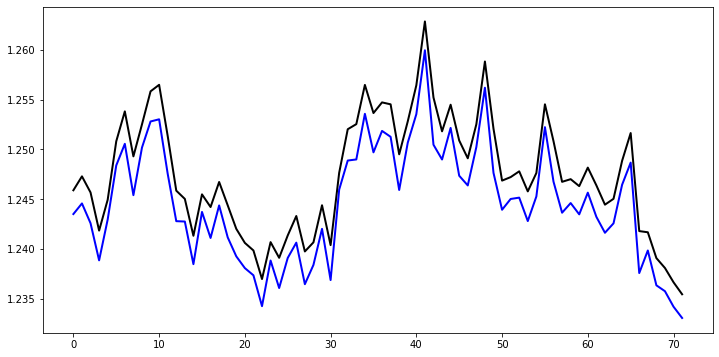

Plot currency  EURNZD


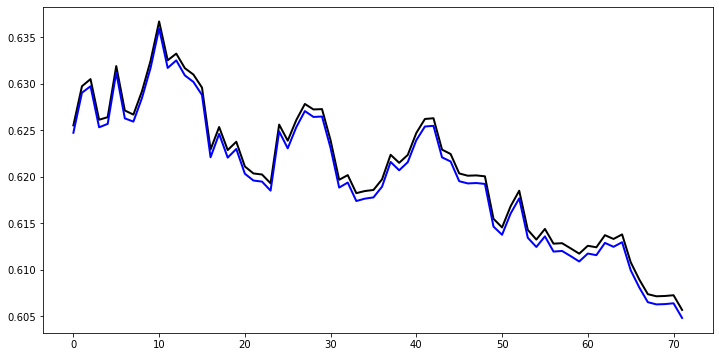

Plot currency  EURPLN


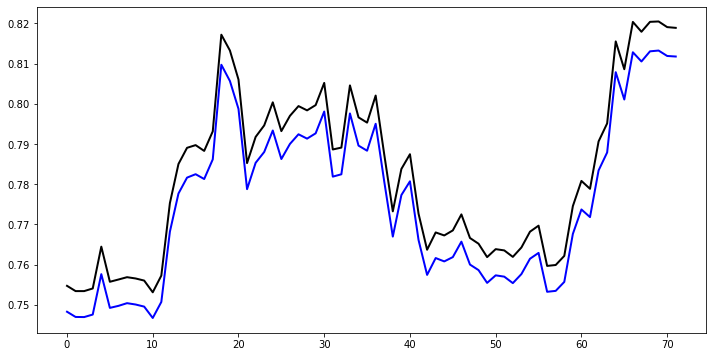

Plot currency  EURRUB


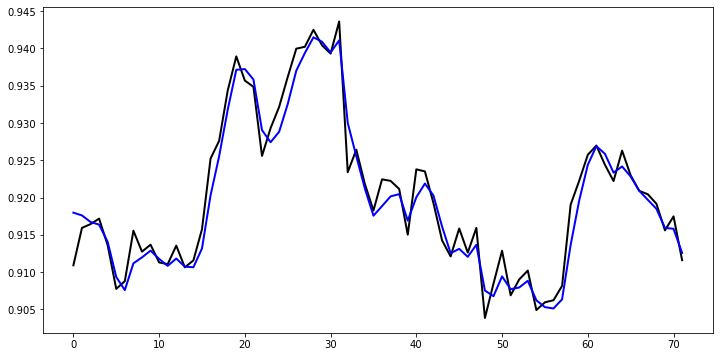

Plot currency  EURRUR


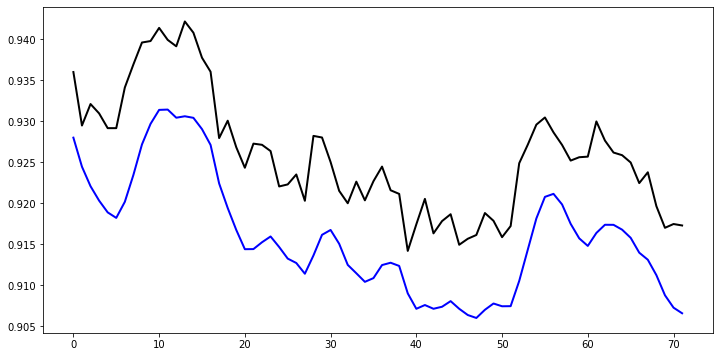

Plot currency  EURSEK


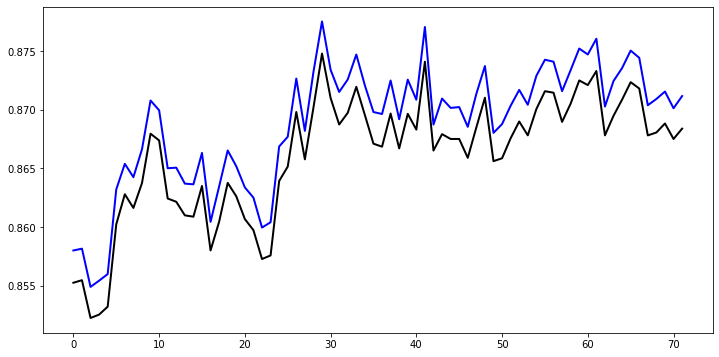

Plot currency  EURTRY


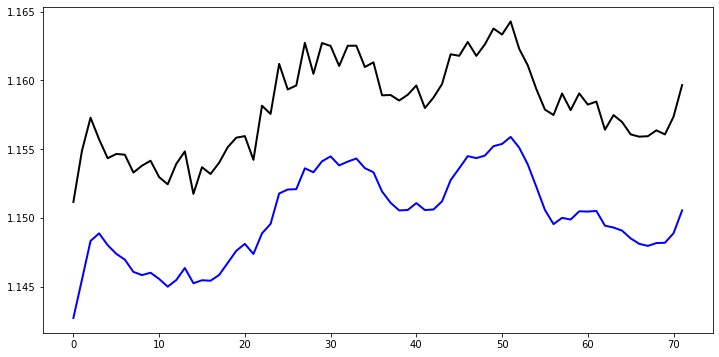

Plot currency  EURZAR


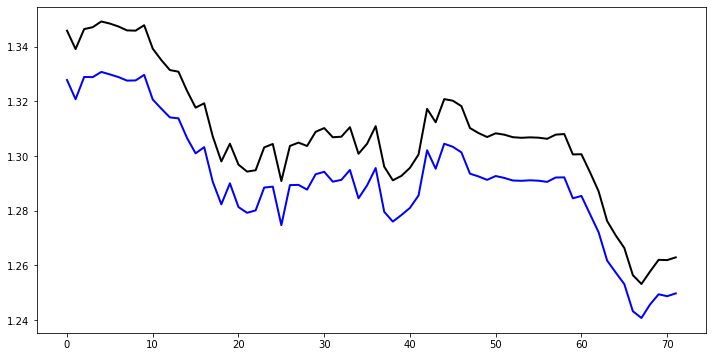

In [15]:
for curr, data in predictions.items():
    xs = np.arange(int(horizon))
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    print('Plot currency ', curr)
    
    y_test = data_curr[curr]['y_test']
    
    ax.plot(xs, y_test[-horizon-1:-1], label='Real ' + curr, lw=2, color='black')
    ax.plot(xs, data[-horizon:], label='Forecast ' + curr, lw=2, color='blue')
    
    plt.show()

In [16]:
def getNonScaledPredictions(data_curr, predictions):
    pred = {}
    for curr, data in data_curr.items():
        
        scaler = data['scaler']
        y_test = data['y_test']
        predict_arr = predictions[curr]
        
        pred[curr] = {
            'real': scaler.inverse_transform(y_test),
            'predict': scaler.inverse_transform(predict_arr)
        }
    return pred
        

In [17]:
pred = getNonScaledPredictions(data_curr, predictions)

horizon = 24*30*1

In [18]:
def getActions(y, V, Cash, T):
    n = V.shape[1]
    t_cur = T
    t_prev = t_cur - 1
    t_prev2 = t_prev - 1
    t_next = t_cur + 1
    
    X_eur = Cash[t_cur, -1]
    X_new = X_eur
    A = []
    
    gap_ref = 10/100
    
    for c in range(n):
        action = ''
        X = 0

        d_cur = y[t_cur, c] - y[t_prev, c]
        d_next = V[t_next, c] - y[t_prev, c]

        if d_cur > 0 and d_next < 0:
            action = 'BUY'

        elif d_cur < 0 and d_next > 0:
            action = 'SELL'
        A.append([action, X])
    
    return A

In [19]:
n = len(pred)

V = np.empty((n, horizon))
y = np.empty((n, horizon))

start_gap = 24*30*6
i = 0

for curr, data in pred.items():
    j1, j2 = 0, 0
    for x in data['predict'][-(start_gap + horizon):-start_gap]:
        V[i, j1] = x
        j1 += 1
    for x in data['real'][-(horizon+start_gap+1):-(start_gap+1)]:
        y[i, j2] = x
        j2 += 1
    i += 1

V = np.array(V)
y = np.array(y)

print(V.shape)
print(y.shape)

V = np.reshape(V, (horizon, len(V)))    
y = np.reshape(y, (horizon, len(y)))
    

initial_cash = 1000
X_buy = 0*V
X_sell = 0*V

Cash = np.zeros((horizon+1, n + 1))
Cash[0, -1] = initial_cash
Cash[1, -1] = initial_cash

for t in range(2, horizon-1):
    A = getActions(y, V, Cash, t)
    Cash[t, :] = Cash[t-1, :]
    b = 0
    c = 0
    
    print('Jour ', t/24)
    for a in A:        
        if a[0] == 'SELL' and Cash[t, c] > 0:
            print(str(a[0]) + ' ' + str(Cash[t, c]) + ' ' + str(curr_key[c]) + ' rate :' + str(y[t, c]))
            
            Cash[t, -1] = Cash[t, -1] + Cash[t, c]/y[t, c]
            Cash[t, c] = Cash[t, c] -  Cash[t, c]
            X_sell[t, c] = 1
            
            
            print('Euro after sell ', Cash[t, -1])
        if a[0] == 'BUY':
            b += 1
        c += 1
          
    c = 0    
    for a in A:
            
        if a[0] == 'BUY' and Cash[t, -1] > 0:
            
            print(str(a[0]) + ' ' + str(Cash[t, -1]*y[t, c]/b) + ' ' + str(curr_key[c]) + ' rate: ' + str(y[t, c]/b))
            
            Cash[t, c] = Cash[t, c] + Cash[t, -1]*y[t, c]/b
            Cash[t, -1] = Cash[t, -1] - Cash[t, -1]/b
            
            print('Euro after buy ', Cash[t, -1])
            X_buy[t, c] = 1
        
        c += 1
    
    print('Actions end of hour: ', A)
    print('Accounts status: ', Cash[t, :])
    last_day = t

final_cash = Cash[last_day, -1]
print(final_cash)
for i in range(n):
    if y[last_day, i] != 0:
        final_cash += Cash[last_day, i]/y[last_day, i]
        initial_cash += Cash[0, i]/y[0, i]

d_growth = (final_cash/initial_cash)**(1/(horizon/24)) - 1
                 
print('Initial cash value (eur): ', initial_cash)
print('Final cash value (eur): ', final_cash)
print('Daily growth: ', d_growth, '%')
print('Win: ', final_cash - initial_cash)

(18, 720)
(18, 720)
Jour  0.08333333333333333
BUY 406.015 EURCAD rate: 0.406015
Euro after buy  750.0
BUY 304.6875 EURUSD rate: 0.40625
Euro after buy  562.5
BUY 228.50859375 EURMXN rate: 0.4062375
Euro after buy  421.875
BUY 171.42890624999998 EURNZD rate: 0.40635
Euro after buy  316.40625
Actions end of hour:  [['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [  0.         406.015        0.           0.           0.
 304.6875       0.           0.           0.           0.
 228.50859375   0.         171.42890625   0.           0.
   0.           0.           0.         316.40625   ]
Jour  0.125
SELL 228.50859375 EURMXN rate :1.62418
Euro after sell  457.0979182572129
SELL 171.42890624999998 EURNZD rate :1.6231200000000001
Euro after sell  562.7148204271078
BUY 457.1129436516547 EURCHF rate: 0.812335
Euro after buy  281.3574102135539
BUY 228.44

Accounts status:  [1.02261352e+03 2.09764595e+00 4.26753768e+01 2.13395787e+01
 4.41802206e+01 7.72428047e-01 2.08770320e+01 1.87597414e+02
 1.70045559e+01 1.82834337e+01 1.65087566e+01 1.02056080e+02
 1.33012052e+01 8.37883332e+01 1.12304484e+01 9.22781124e+00
 9.50428036e+00 9.04880643e+00 5.07359701e-01]
Jour  2.8333333333333335
BUY 0.06735569025283035 EURAUD rate: 0.13275727272727272
Euro after buy  0.46123609220402484
BUY 0.061223220962547155 EURCAD rate: 0.13273727272727273
Euro after buy  0.41930553836729534
BUY 0.05565785478916867 EURCHF rate: 0.13273818181818184
Euro after buy  0.3811868530611776
BUY 0.05054710938342606 EURGBP rate: 0.13260454545454545
Euro after buy  0.34653350278288875
BUY 0.04592482500198794 EURJPY rate: 0.13252636363636364
Euro after buy  0.3150304570753534
BUY 0.04177504334746416 EURUSD rate: 0.13260636363636366
Euro after buy  0.2863913246139576
BUY 0.037969501461568855 EURCZK rate: 0.13257909090909092
Euro after buy  0.2603557496490524
BUY 0.03452151559

Euro after buy  796.6340971388854
BUY 42.265422023703564 EURSEK rate: 0.053055
Euro after buy  746.8444660677051
BUY 39.48893436553861 EURTRY rate: 0.052874374999999994
Euro after buy  700.1666869384735
Actions end of hour:  [['SELL', 0], ['SELL', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0]]
Accounts status:  [  0.           0.         103.58736542  97.15348064  91.04898363
  85.30373962  80.03206492  75.11283227  70.35903862  66.06094318
  61.95633477  58.21194174  54.52793263  51.19667808  47.94986658
  45.00717104  42.26542202  39.48893437 700.16668694]
Jour  5.791666666666667
BUY 295.8834402333295 EURAUD rate: 0.42258999999999997
Euro after buy  350.08334346923675
BUY 147.70716427654037 EURCAD rate: 0.42191999999999996
Euro after buy  175.04167173461838
Actions end of hour:  [['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0]

Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0]]
Accounts status:  [24145.43343488 16097.6802609  10721.35205857     0.
  9556.99006251     0.         17138.76799105 15713.93410626
 14406.38566993 13205.61567746 12104.92967214 11095.3860814
 10173.88510402  9327.06898721  8549.73626564  7836.97601048
     0.          6583.57670762 25820.58353725]
Jour  8.958333333333334
SELL 13205.615677460597 EURHUF rate :1.10666
Euro after sell  37753.44067265278
SELL 12104.929672139595 EURMXN rate :1.1067
Euro after sell  48691.30068181479
SELL 11095.386081397248 EURNOK rate :1.10651
Euro after sell  58718.67149762057
SELL 10173.88510401644 EURNZD rate :1.107
Euro after sell  67909.17294659658
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['SELL', 0], ['SELL', 0], ['SELL', 0], ['', 0], ['', 0

Actions end of hour:  [['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [4.82244629e+03 0.00000000e+00 5.59913402e+04 1.61143545e+05
 9.87408744e+05 2.06340767e+05 6.44233777e+05 5.59308439e+05
 5.11525650e+05 3.59152909e+05 4.06874830e+05 2.84375964e+05
 3.06816961e+05 2.94253359e+02 2.03564687e+03 5.16689813e+05
 1.94711268e+04 4.30699794e+03 5.35073968e+01]
Jour  11.166666666666666
SELL 511525.65042270947 EURHKD rate :25.51
Euro after sell  20105.473309126108
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [4.82244629e+03 0.00000000e+00 5.59913402e+04 1.61143545e+05
 9.87408744e+05 2.06340767e+05 6.44233777e+05 5.59308439e+05
 0.00000000e+00 3.59152909e+05 4.06874830e+05 2.843759

Accounts status:  [     0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
  18311.54673293      0.         671271.75255844]
Jour  13.375
Actions end of hour:  [['', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [     0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
  18311.54673293      0.         671271.75255844]
Jour  13.416666666666666
BUY 5868761.114680303 EURHUF rate: 8.74275
Euro after buy  0.0
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['', 0], ['BUY', 0]

 6.46860277e+05 4.11786461e+06 3.76513953e+02]
Jour  15.833333333333334
BUY 1602.4366073809895 EURJPY rate: 4.255982
Euro after buy  301.21116252483955
BUY 1280.4462422037927 EURDKK rate: 4.250992
Euro after buy  240.96893001987164
BUY 1024.9464037658627 EURHKD rate: 4.253438
Euro after buy  192.7751440158973
BUY 820.6299082653056 EURHUF rate: 4.256928
Euro after buy  154.22011521271784
BUY 655.9323868652663 EURMXN rate: 4.253222
Euro after buy  123.37609217017427
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [5.35813817e+05 2.31076297e+05 9.64141873e+04 9.16730728e+04
 1.30407711e+05 1.20735688e+06 1.01206659e+05 7.00862785e+04
 9.49612525e+04 8.79121614e+04 8.13253491e+04 9.62399072e+04
 3.37710168e+03 6.40560704e+04 5.93568833e+04 8.43384261e+05
 6.46860277e+05 4.11786461e+06 1.23376092e+02]
Jour  15.875
BUY 374.8

Euro after buy  133736.07066567184
BUY 76489.45404342658 EURCAD rate: 0.5719433333333334
Euro after buy  89157.38044378124
BUY 50932.63953485076 EURCHF rate: 0.5712666666666667
Euro after buy  59438.253629187486
Actions end of hour:  [['BUY', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [ 114780.32000952   76489.45404343  175993.88164657  376139.48752666
   95781.30233737  637210.80459432 1969804.29268276  253614.86184663
 1601561.57812262  200600.96896952  371752.4918582   336125.62851953
  140788.31123917  259064.29627171  198663.74070519  264068.85175145
  165299.36472596  167502.84061348   59438.25362919]
Jour  18.666666666666668
BUY 101101.49751056645 EURSEK rate: 1.70095
Euro after buy  0.0
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], 

Euro after buy  522945.54105842044
BUY 280945.9551143732 EURUSD rate: 0.5372375
Euro after buy  457577.3484261179
BUY 245764.79383966795 EURCZK rate: 0.5371
Euro after buy  400380.17987285316
BUY 215024.1756007158 EURRUR rate: 0.53705
Euro after buy  350332.6573887465
BUY 188154.91196706102 EURSEK rate: 0.537075
Euro after buy  306541.07521515316
BUY 164639.3797346186 EURTRY rate: 0.5370875
Euro after buy  268223.440813259
Actions end of hour:  [['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['BUY', 0]]
Accounts status:  [      0.               0.          419263.88819962  366891.76129748
  321028.79700518  987483.53394094  245764.79383967 2648866.63222604
       0.               0.               0.               0.
 1987852.68679971 2390073.4450015  1555487.04263804  461491.96194697
  188154.91196706  596108.03424797  268223.44081326]
Jour  21.0
BUY 288112.208

c:\users\jonat\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in double_scalars
c:\users\jonat\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
c:\users\jonat\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars



Jour  25.708333333333332
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 nan]
Jour  25.75
Actions end of hour:  [['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 nan]
Jour  25.791666666666668
Actions end of hour:  [['', 0], ['SELL', 0], ['', 0], ['', 0], ['BUY', 0], ['BUY', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['SELL', 0], ['SELL', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0], ['', 0]]
Accounts status:  [nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 nan]
Jour  25.833333333333332
Actions end of hour:  [['', 0], ['BUY', 0], [

Plot currency  EURAUD


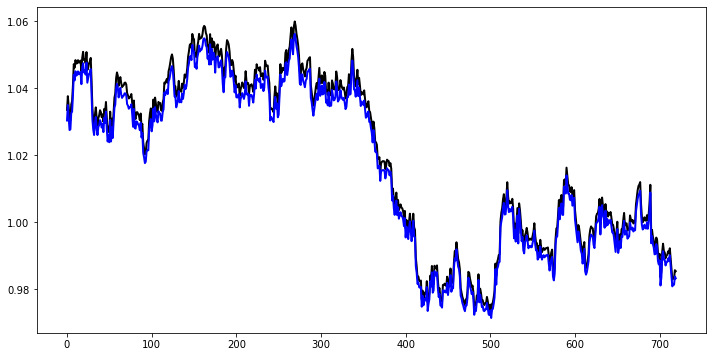

Plot currency  EURCAD


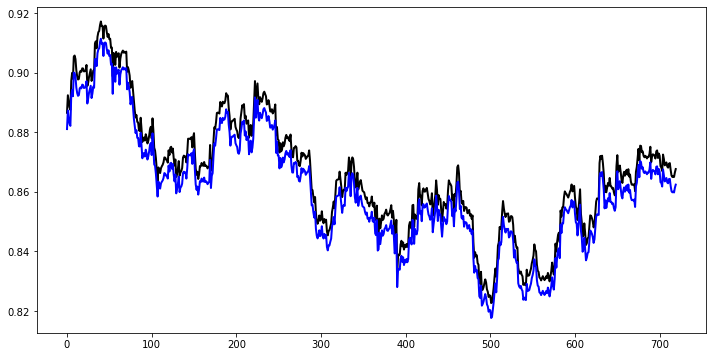

Plot currency  EURCHF


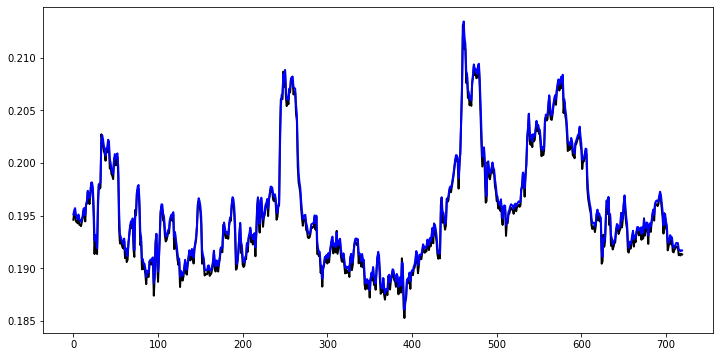

Plot currency  EURGBP


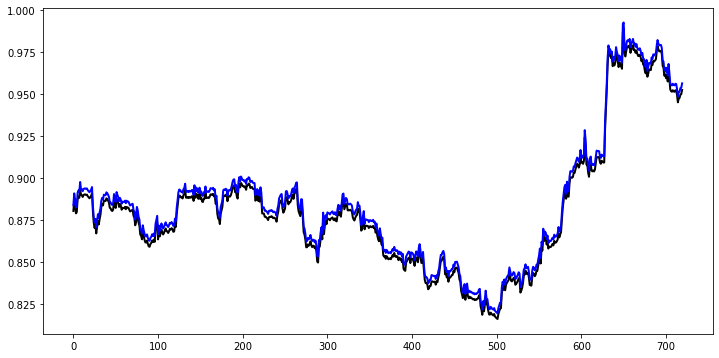

Plot currency  EURJPY


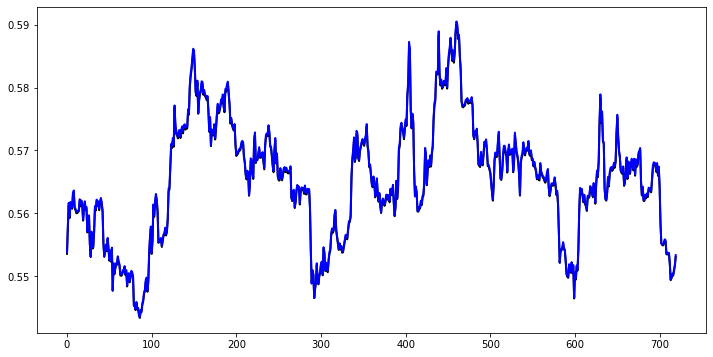

Plot currency  EURUSD


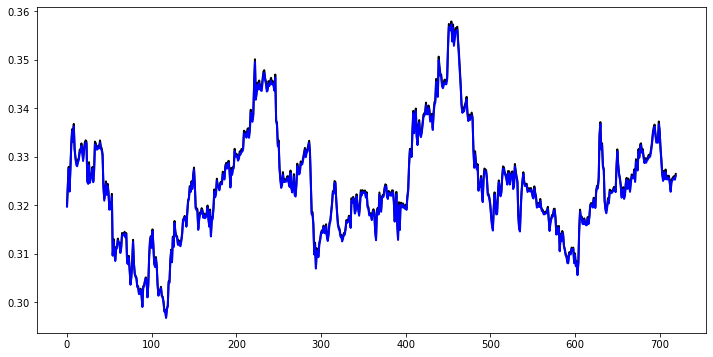

Plot currency  EURCZK


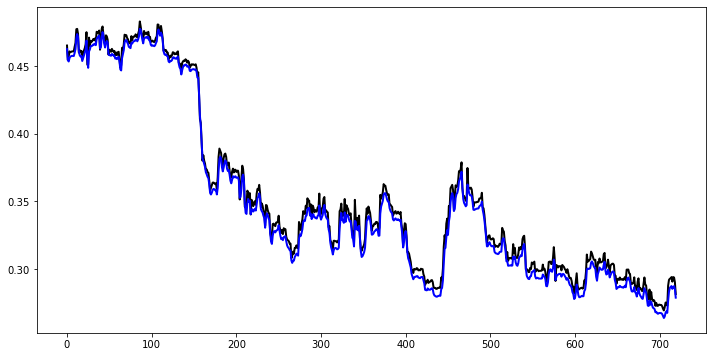

Plot currency  EURDKK


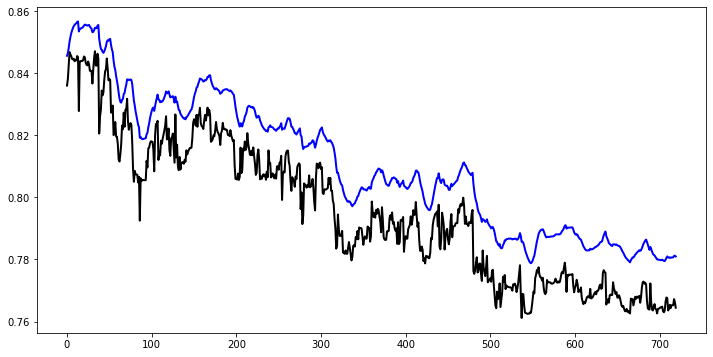

Plot currency  EURHKD


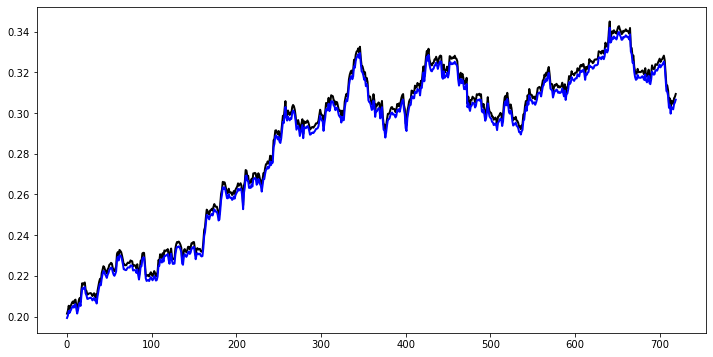

Plot currency  EURMXN


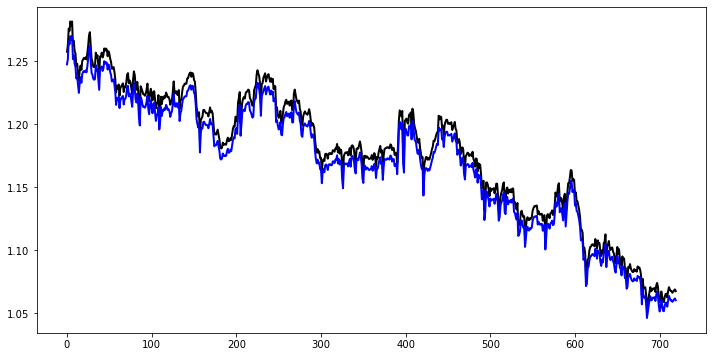

Plot currency  EURNOK


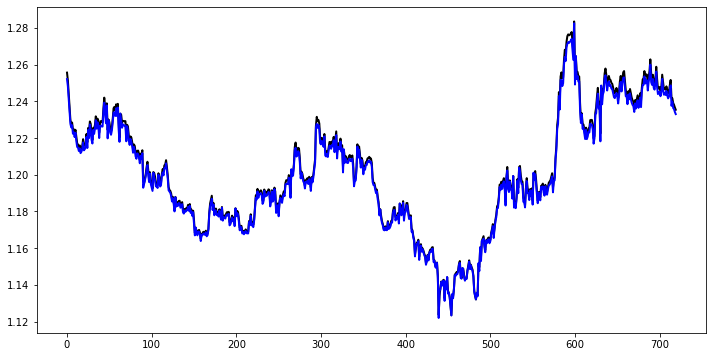

Plot currency  EURNZD


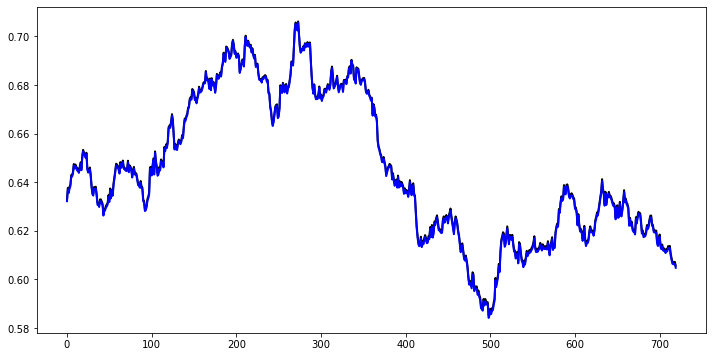

Plot currency  EURPLN


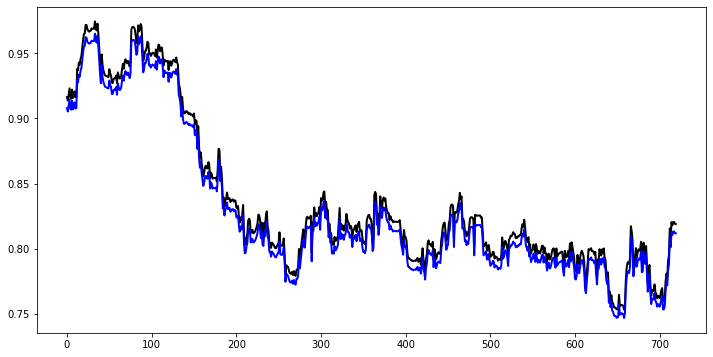

Plot currency  EURRUB


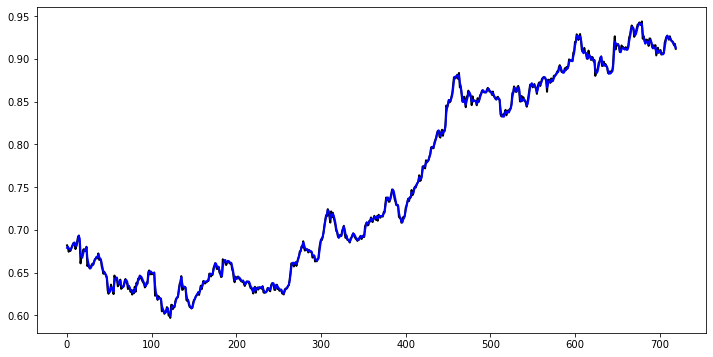

Plot currency  EURRUR


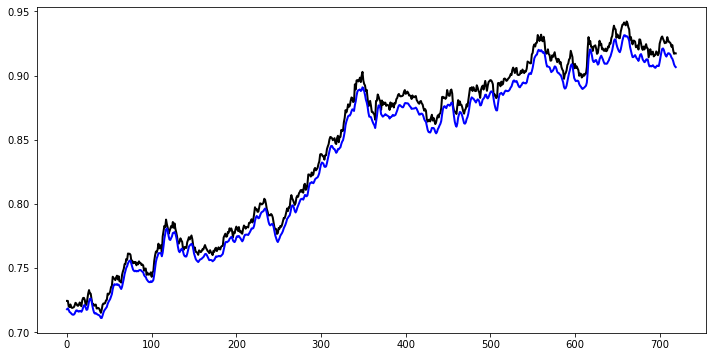

Plot currency  EURSEK


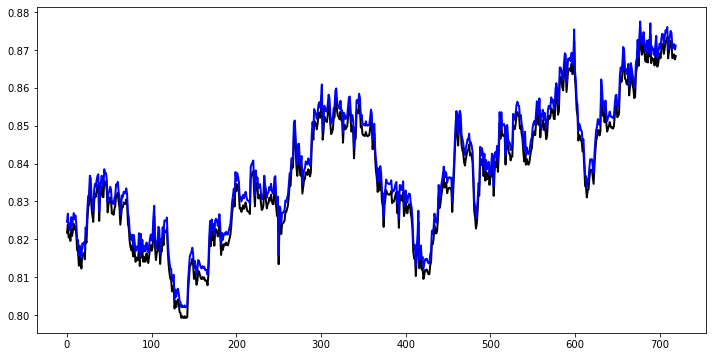

Plot currency  EURTRY


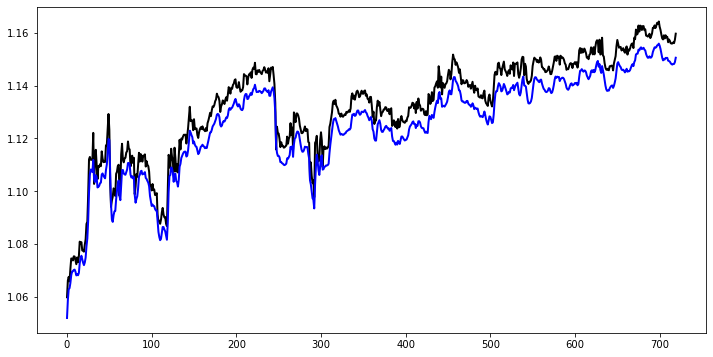

Plot currency  EURZAR


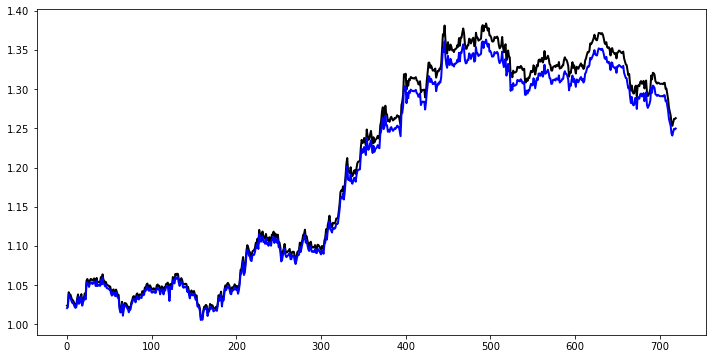

In [20]:
for curr, data in predictions.items():
    xs = np.arange(int(horizon))
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    print('Plot currency ', curr)
    
    y_test = data_curr[curr]['y_test']
    
    ax.plot(xs, y_test[-horizon-1:-1], label='Real ' + curr, lw=2, color='black')
    ax.plot(xs, data[-horizon:], label='Forecast ' + curr, lw=2, color='blue')
    
    plt.show()

NameError: name 'Cash' is not defined

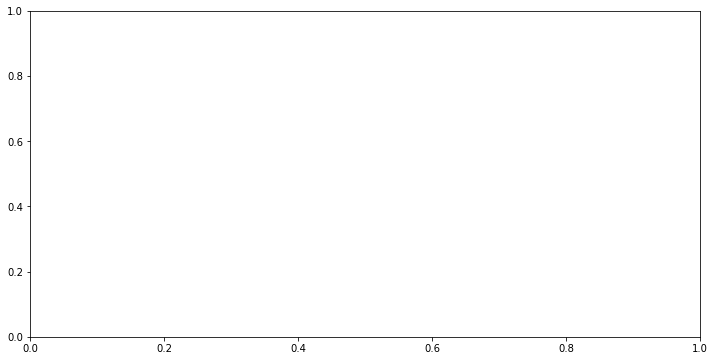

In [29]:
xs = np.arange(int(horizon))
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(xs, Cash[-horizon-1:-1, -1], label='Cash évolution in EUR', lw=2, color='black')
    
plt.show()